In [ ]:
#hide
!nvidia-smi

Tue Jan 19 14:56:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 194kB 7.8MB/s 
     |████████████████████████████████| 163kB 8.0MB/s 
     |████████████████████████████████| 1.9MB 13.4MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 245kB 51.3MB/s 
     |████████████████████████████████| 17.7MB 199kB/s 
     |████████████████████████████████| 163kB 55.7MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 133kB 55.4MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 71kB 11.4MB/s 


In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# enwik8 - Reversible

In [ ]:
from fastai.text.all import *
from reformer_fastai.all import *

## Experiment Tracking

Make sure you have wandb and are logged in

In [ ]:
#hide
# !wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb
from reformer_fastai.tracking import WandbCallback

WANDB_NAME = 'enc_lm_enwik8_reversible_af'
GROUP = 'TEST'
NOTES = 'ReversibleLM on enwik8 sl 4096'
CONFIG = {}
TAGS = ['lm','rev','enwik8']

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
path = untar_data('http://mattmahoney.net/dc/enwik8.zip', dest='./data')

## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines(path)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min 7s, sys: 2.17 s, total: 2min 9s
Wall time: 2min 7s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
#hide
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [ ]:
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
%%time
bs, sl = 2, 4096
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, val_bs=2*bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 30.5 s, sys: 1.8 s, total: 32.3 s
Wall time: 37.8 s


In [ ]:
#collapse_output
dls.show_batch(max_n=2)

,text,text_
0,"\n\n\nThe result was the [[Battle of Adowa]] (or ''Adua'') on [[March 1]], [[1896]]. Almost half of all the Italian forces in East Africa were concentrated and engaged the Ethiopians who defeated them decisively. The actual battle took place in mountainous county to the north of the town of Adowa. The Italian army comprised four brigades totalling approximately 20,000 troops, with fifty-six artillery pieces. One brigade under General Albertone was made up of Italian officered askari (native infantry) recruited from Eritrea. The remaining three brigades were Italian units under Generals Damorida, Ellena and Baratieri. The Ethiopian forces under Menelik outnumbered the Italians by an estimated five or six times. On the night of [[29 February]] the four brigades advanced separately towards Adowa over narrow mountain tracks. Menlik's large forces were due to retire back into Ethiopia that same day as their food supplies ran low. Learning of the Italian advance Menlik","\n\nThe result was the [[Battle of Adowa]] (or ''Adua'') on [[March 1]], [[1896]]. Almost half of all the Italian forces in East Africa were concentrated and engaged the Ethiopians who defeated them decisively. The actual battle took place in mountainous county to the north of the town of Adowa. The Italian army comprised four brigades totalling approximately 20,000 troops, with fifty-six artillery pieces. One brigade under General Albertone was made up of Italian officered askari (native infantry) recruited from Eritrea. The remaining three brigades were Italian units under Generals Damorida, Ellena and Baratieri. The Ethiopian forces under Menelik outnumbered the Italians by an estimated five or six times. On the night of [[29 February]] the four brigades advanced separately towards Adowa over narrow mountain tracks. Menlik's large forces were due to retire back into Ethiopia that same day as their food supplies ran low. Learning of the Italian advance Menlik"
1,"[[1415]] - [[Manuel Chrysoloras]], Greek humanist\nThrough the global influence of native English speakers in [[film|cinema]], [[airline]]s, [[broadcasting]], [[science]], and the [[Internet]] in recent decades, English is now the most widely learned [[second language]] in the world, although other languages such as [[French language|French]] and [[Spanish]] also retain much importance worldwide.\n[[it:19 febbraio]]\nThe Orthodox Christian tradition is generally much less legalistic, and treats many of the canons more as guidelines than as absolute laws, adjusting them to cultural and other local circumstances. Some Orthodox canon scholars point out that, had the [[Ecumenical Councils]] (which deliberated in Greek) meant for the canons to be used as laws, they would have called them ''nomoi/&amp;#957;&amp;#959;&amp;#956;&amp;#959;&amp;#953;'' (laws) rather than ''kanones/&amp;#954;&amp;#945;&amp;#957;&amp;#959;&amp;#957;&amp;#949;&amp;#962;'' (standards).\n| males age 15-49: '''1,913,857''' (2000 est.)\n[[Category:Knowledge representation]]\n* [http://www.cathar.info/dualism.htm Dualism] and the relationship between Manichaeism, Bogomilism and Catharism\n\n <timestamp>2004-12-03T22:42:10Z</timestamp>\n <username>Camembert</username>\n","[1415]] - [[Manuel Chrysoloras]], Greek humanist\nThrough the global influence of native English speakers in [[film|cinema]], [[airline]]s, [[broadcasting]], [[science]], and the [[Internet]] in recent decades, English is now the most widely learned [[second language]] in the world, although other languages such as [[French language|French]] and [[Spanish]] also retain much importance worldwide.\n[[it:19 febbraio]]\nThe Orthodox Christian tradition is generally much less legalistic, and treats many of the canons more as guidelines than as absolute laws, adjusting them to cultural and other local circumstances. Some Orthodox canon scholars point out that, had the [[Ecumenical Councils]] (which deliberated in Greek) meant for the canons to be used as laws, the

In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([8, 1024]), torch.Size([8, 1024]))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
#opt_func = partial(adafactor, warmup_init=True)
opt_func = adafactor

learn = Learner(dls, ReversibleLM(vocab_sz, 1024, n_layers=3, max_seq_len=sl, rev_thres=4097), #using irrev blocks for speed
                loss_func=CrossEntropyLossFlat(), opt_func=opt_func,
                metrics=[accuracy, perplexity, bpc],
                cbs = [GradientAccumulation(n_acc=8), GradientClip(), TerminateOnNaNCallback()]).to_fp16()

In [ ]:
#hide
# learn.lr_find()

In [ ]:
learn.fit(1, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.638108,1.559506,0.543857,4.756472,2.249892,2:21:43


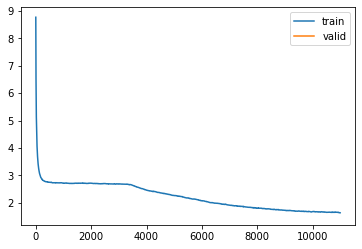

In [ ]:
learn.recorder.plot_loss()